In [27]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, join, hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

In [28]:
drpFile = fits.open('mpl10/drpall-v3_0_1.fits')
drp = Table(drpFile[1].data)
drp = drp[(drp['srvymode'] == 'MaNGA dither')]

# Find all MaNGA galaxy data cubes
cube_bools = (drp['mngtarg1'] != 0) | (drp['mngtarg3'] != 0)
galaxies = drp[cube_bools]
print('Number of galaxies', len(galaxies))

# Get unique galaxies to remove duplicate obesrvations
uniq_vals, uniq_idx=np.unique(galaxies['mangaid'], return_index=True)
uniq_galaxies = galaxies[uniq_idx]
print('Unique galaxies', len(uniq_galaxies))

# So that later all other catalogs will be sorted by plate-ifu numbers and indices will be the same
uniq_galaxies.sort('plateifu') 



mangaRA = uniq_galaxies['objra']; mangaDEC = uniq_galaxies['objdec']


print('The total number of galaxies in MPL-10 MaNGA survey is ' + str(len(drp)))

Number of galaxies 9710
Unique galaxies 9496
The total number of galaxies in MPL-10 MaNGA survey is 9743


In [29]:
nsa = fits.open('nsa_v1_0_1.fits')[1] # NSA data file
nsaRA = nsa.data['RA']; nsaDEC = nsa.data['DEC']

In [30]:
# match the two catalogs on the basis of right ascension and declination
c = SkyCoord(ra=mangaRA*u.degree, dec=mangaDEC*u.degree)
catalog = SkyCoord(ra=nsaRA*u.degree, dec=nsaDEC*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

nsaMaNGA = Table(nsa.data[idx]) # nsa catelog matched by RA and DEC to 

In [31]:
nsaMaNGA.rename_column('NSAID', 'nsa_nsaid')
nsaid_match = np.isin(uniq_galaxies['nsa_nsaid'], nsaMaNGA['nsa_nsaid'])
edge = abs(uniq_galaxies['nsa_sersic_ba']) < 0.3 # ba ratio less than 0.3 is our definition for edge-on
late = (nsaMaNGA['ELPETRO_TH90_R'] / nsaMaNGA['ELPETRO_TH50_R']) < 2.6

In [32]:
print(str(len(uniq_galaxies)) + ',   ' + str(len(uniq_galaxies[late & edge])) + '\n' +
      str(len(uniq_galaxies[nsaid_match])) + ',   ' + str(len(uniq_galaxies[nsaid_match & late & edge]))      
     )

9496,   868
9379,   866


In [33]:
# read in MPA-JHU catalog information
mpa_jhu_dir = '/Users/rminsley/bates_thesis/'
gal = fits.open(mpa_jhu_dir + 'gal_info_dr7_v5_2.fit');        galdata = gal[1].data 
sfr = fits.open(mpa_jhu_dir + 'gal_totsfr_dr7_v5_2.fits');     sfrdata = sfr[1].data
mass = fits.open(mpa_jhu_dir + 'totlgm_dr7_v5_2.fit');         massdata = mass[1].data


mpaRA = galdata.field('RA'); mpaDEC = galdata.field('DEC')
bad = mpaDEC < -90
mpaDEC[bad] = -90

mpa_cat = SkyCoord(ra=mpaRA*u.degree, dec=mpaDEC*u.degree)
idx_mpa, d2d_mpa, d3d_mpa = c.match_to_catalog_sky(mpa_cat)

In [34]:
# Concentration 
concentration = (nsaMaNGA['ELPETRO_TH90_R'] / nsaMaNGA['ELPETRO_TH50_R'])[nsaid_match]     # bin=np.arange(.9,4.1,0.05)
conc_late =  (nsaMaNGA['ELPETRO_TH90_R'] / nsaMaNGA['ELPETRO_TH50_R'])[nsaid_match & late] # bin=np.arange(.9,2.7,0.05)

# Log stellar mass 
stmass = massdata['MEDIAN'][idx_mpa][nsaid_match]
stmass_late = massdata['MEDIAN'][idx_mpa][nsaid_match & late]
stmass_sample = massdata['MEDIAN'][idx_mpa][nsaid_match & late & edge]

# b/a ratio 
ba = uniq_galaxies['nsa_sersic_ba'][nsaid_match]                      # bins=np.arange(.15,1.1,0.02)
ba_late = uniq_galaxies['nsa_sersic_ba'][nsaid_match & late]          # bins=np.arange(.15,1.1,0.02)
ba_sample = uniq_galaxies['nsa_sersic_ba'][nsaid_match & late & edge] # bins=np.arange(.15,0.35,0.02)


# g-r color 
absmag = uniq_galaxies['nsa_elpetro_absmag']
gr = (absmag[:,3] - absmag[:,4])[nsaid_match]
gr_late = (absmag[:,3] - absmag[:,4])[nsaid_match & late]
gr_sample = (absmag[:,3] - absmag[:,4])[nsaid_match & late & edge]

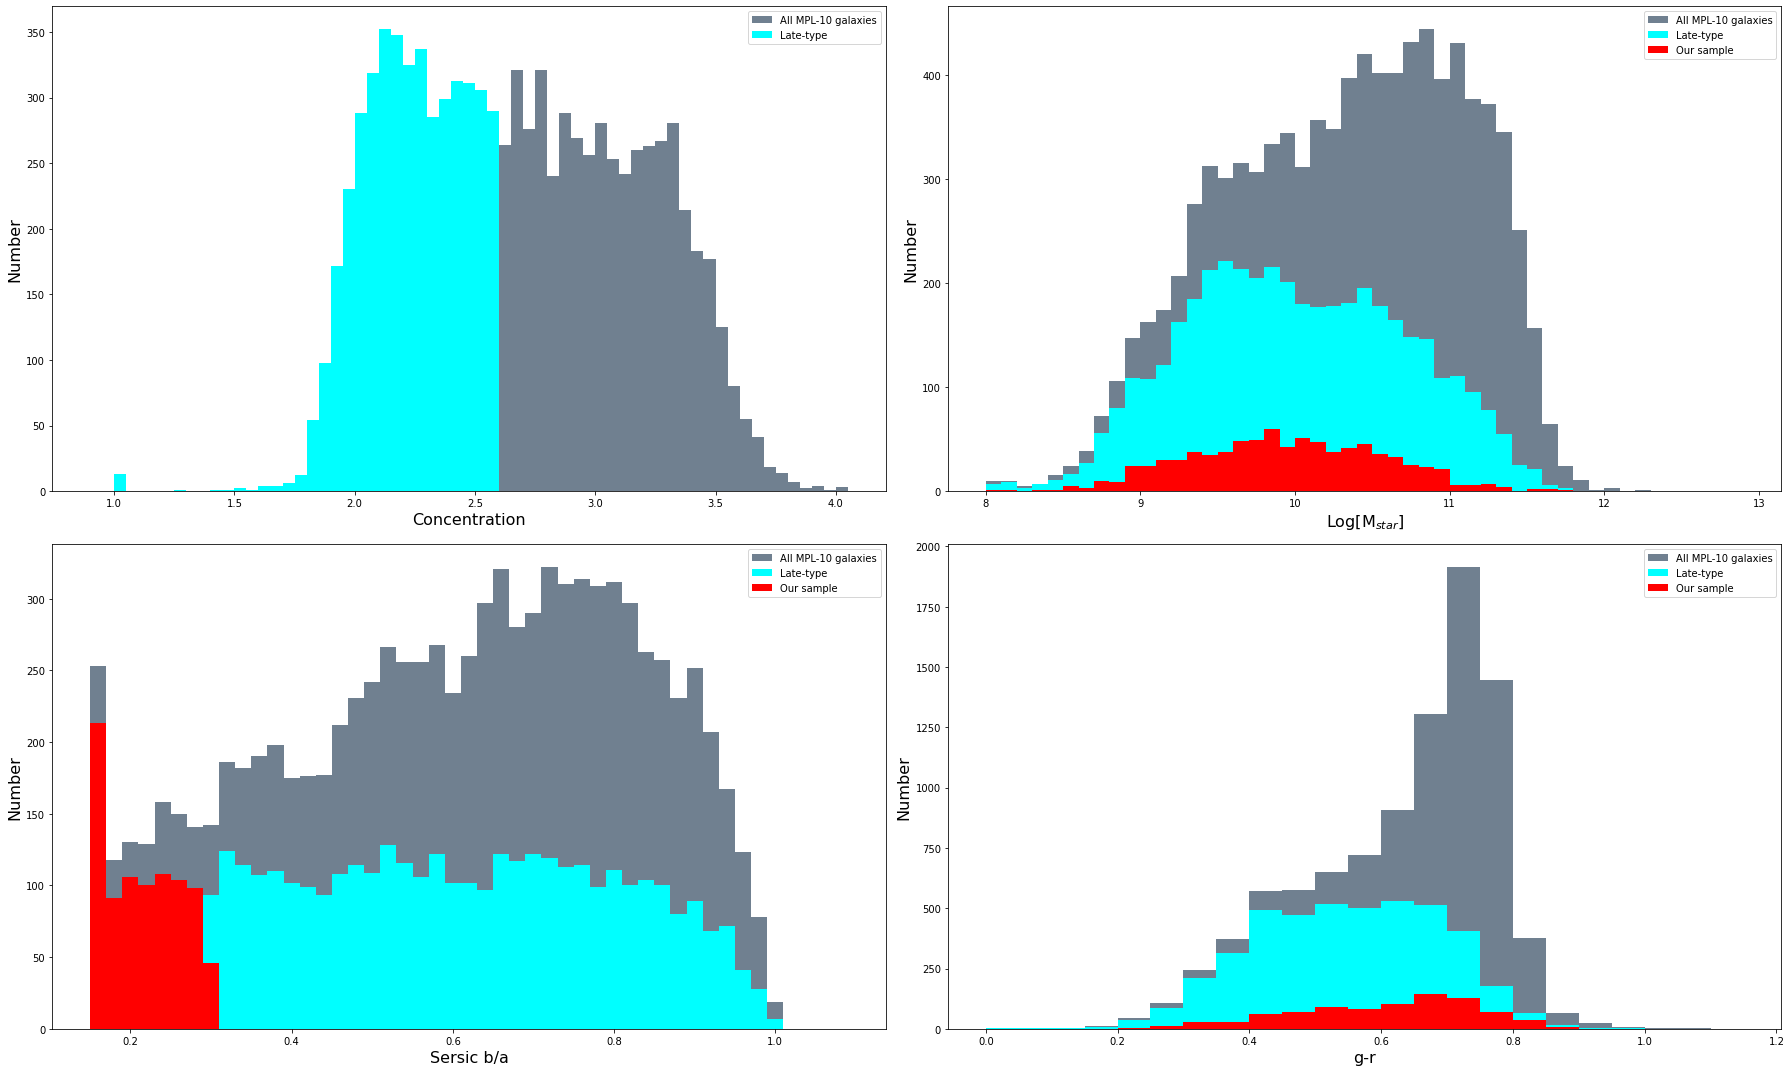

In [35]:
fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(25, 15))

# Concentration 
axes[0,0].hist(concentration, bins=np.arange(.9,4.1,0.05), color='slategrey', label= 'All MPL-10 galaxies')
axes[0,0].hist(conc_late,bins=np.arange(.9,2.7,0.05), color='cyan', label= 'Late-type')
axes[0,0].set_xlabel('Concentration', size=16)
axes[0,0].set_ylabel('Number', size=16)
axes[0,0].legend()

# Stellar Mass
axes[0,1].hist(stmass,bins=np.arange(8,13,0.1), color='slategrey', label= 'All MPL-10 galaxies')
axes[0,1].hist(stmass_late, bins=np.arange(8,11.9,0.1), color='cyan', label= 'Late-type')
axes[0,1].hist(stmass_sample, bins=np.arange(8,11.8,0.1), color='red', label= 'Our sample')
axes[0,1].set_xlabel(r'Log[M$_{star}$]', size=16)
axes[0,1].set_ylabel('Number', size=16)
axes[0,1].legend()

# b/a Mass
axes[1,0].hist(ba,bins=np.arange(.15,1.1,0.02), color='slategrey', label= 'All MPL-10 galaxies')
axes[1,0].hist(ba_late, bins=np.arange(.15,1.1,0.02), color='cyan', label= 'Late-type')
axes[1,0].hist(ba_sample, bins=np.arange(.15,0.35,0.02), color='red', label= 'Our sample')
axes[1,0].set_xlabel('Sersic b/a', size=16)
axes[1,0].set_ylabel('Number', size=16)
axes[1,0].legend()

# g-r color distribution 
axes[1,1].hist(gr, bins=np.arange(0,1.2,0.05), color='slategrey', label= 'All MPL-10 galaxies')
axes[1,1].hist(gr_late, bins=np.arange(0,1.2,0.05), color='cyan', label= 'Late-type')
axes[1,1].hist(gr_sample, bins=np.arange(0,1.2,0.05), color='red', label= 'Our sample')
axes[1,1].set_ylabel('Number', size=16)
axes[1,1].set_xlabel('g-r', size=16)
axes[1,1].legend()

plt.tight_layout()

In [36]:
uniq_galaxies[nsaid_match & edge & late]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,str32,str32,str32,str32,str32,str32,str32,str32,str32,str32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,str53,int64,str32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,str32,int64,str19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12703,10001-12703,1-55648,v3_0_1,v3_0_1,v1_8_1,v5_5_35,v2_8,APOGEE-2&MaNGA,MaNGA dither,136.017159969,57.0923291779,159.56459216,40.3368076472,136.01716,57.092329,0.0258626,9,8100.81,0,19.9086,40.7596,ma077,31,3,9114,134.41357,57.604214,1.09975,1.13824,1.19323,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.72679,2.61381,2.56484,2.53,2080,0,0,1,plateTargets-1.par,6013,J090404.13+570532.3,127,169,0,0.0462094,0.0227277,0.0296235,0.0443908,0.0487145,0.0222592,0.03022,0.55597,-999.0,0.570051,0.643308,0.979861,1.21834,-999.0,0.534143,0.597944,39,3600,2,v1_0_1,59078,-999,0.0462094,0.046579,-15.9552 .. -20.5965,-16.3926 .. -20.4663,223.74 .. 875.365,13693500000.0,9439710000.0,0.378034,51.5052,0.219711 .. 0.0391981,6.523,4.87172,13.8626 .. 635.975,1.79171 .. 0.00598687,14.4442 .. 722.823,1.96905 .. 0.00930865,0.205749,2.18084,51.2808,8.09139,9.82225 .. 820.242,2.79287 .. 0.0443689
10001,12704,10001-12704,1-55616,v3_0_1,v3_0_1,v1_8_1,v5_5_35,v2_8,APOGEE-2&MaNGA,MaNGA dither,133.989966869,57.6779676669,159.101196491,39.1494998661,133.98997,57.677968,0.0476794,9,8100.81,64,19.9086,40.7596,ma076,34,3,9114,134.41357,57.604214,1.10705,1.15123,1.21051,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.68039,2.59244,2.52842,2.4833,4160,0,0,1,plateTargets-1.par,6013,J085557.56+574040.6,127,397,0,0.0141215,0.0183756,0.0258019,0.037294,0.0415338,0.0141373,0.0310467,0.67973,-999.0,-999.0,-999.0,-999.0,-999.0,0.716568,0.45291,0.474847,36,3600,5,v1_0_1,59044,-999,0.0141215,0.0145852,-14.2399 .. -19.4321,-14.2982 .. -19.3602,262.464 .. 794.079,4286640000.0,4218380000.0,0.212315,81.0961,0.388503 .. 0.0693118,16.0734,11.44,18.0685 .. 2387.32,0.731053 .. 1.94195e-05,18.855 .. 2747.21,1.50036 .. 0.000434694,0.15,0.869326,81.2193,18.2816,17.8616 .. 2923.9,2.16404 .. 0.00123046
10213,12703,10213-12703,1-44990,v3_0_1,v3_0_1,v1_8_1,v5_5_35,v2_8,APOGEE-2&MaNGA,MaNGA dither,123.132893944,44.3009344657,175.789632166,32.6275191589,123.13289,44.300934,0.0542657,9,8100.71,64,21.8551,32.982,ma143,31,5,10670,122.76456,42.985153,1.02125,1.05633,1.15253,1.20531,1.31546,1.52985,0.948978,0.96966,0.981958,58080,58080,58080,2.46513,2.42417,2.41714,2.42035,2080,0,0,1,plateTargets-1.par,6081,J081231.91+4418